In [148]:
# working with directories
import os

# working with numbers
import pandas as pd
import numpy as np
from tqdm import tqdm

# reading images
from PIL import Image

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
weather_dict = {}
for wc in os.listdir("Dataset"):
    for wi in os.listdir(f"Dataset/{wc}"):
        weather_dict[wi] = wc

In [139]:
# set up a dataframe and get image names and respective weathers
df = pd.DataFrame.from_dict(weather_dict, orient='index')
df.reset_index(inplace=True)
df.columns = ['img_name', 'weather']
df = df.loc[:, ['weather', 'img_name']]

# get image paths
df['path'] = 'Dataset/'+df.weather + '/' + df.img_name

# get image resolutions
df['resolution'] = [Image.open(path).size for path in tqdm(df.path)]

# split resolution in width and height columns
df['width'] = df.resolution.str[0]
df['height'] = df.resolution.str[1]

df.sample(10)

100%|██████████| 6737/6737 [00:00<00:00, 7562.30it/s]


weather  img_name                        path  resolution  width  \
5390       rime  5931.jpg       Dataset/rime/5931.jpg  (400, 267)    400   
4947       rime  5488.jpg       Dataset/rime/5488.jpg  (800, 682)    800   
5722  sandstorm  3081.jpg  Dataset/sandstorm/3081.jpg  (400, 255)    400   
4063       rain  1735.jpg       Dataset/rain/1735.jpg  (387, 240)    387   
3490  lightning  2066.jpg  Dataset/lightning/2066.jpg  (922, 543)    922   
2909       hail  0246.jpg       Dataset/hail/0246.jpg  (400, 299)    400   
2528      glaze  6594.jpg      Dataset/glaze/6594.jpg  (400, 240)    400   
5010       rime  5551.jpg       Dataset/rime/5551.jpg  (400, 300)    400   
779     fogsmog  4156.jpg    Dataset/fogsmog/4156.jpg  (400, 255)    400   
2486      glaze  6552.jpg      Dataset/glaze/6552.jpg  (400, 264)    400   

      height  
5390     267  
4947     682  
5722     255  
4063     240  
3490     543  
2909     299  
2528     240  
5010     300  
779      255  
2486     264

In [140]:
# Check if all the images have the same extension
df.img_name.str.split('.').str[1].unique()

array(['jpg'], dtype=object)

In [141]:
grouped = df.groupby('weather')['img_name'].count().to_frame()
grouped.reset_index(inplace=True)
grouped.columns = ['Weather', 'Count']

In [181]:
fig = px.bar(grouped, x='Weather', y='Count', 
             title='<b>Number of images by each weather category</b>', 
             color='Count') 

fig.update_layout(
    font_family="Courier New, monospace",
    font_size=12,
    font_color="#0c8df5",
    title_font_color="#0c8df5",
    title_font_family="Courier New, monospace",
)

fig.show()

In [310]:
# define function to plot images
def image_plots(df, nrows, ncols, width, height, show_resolution=False):
    # create the figure
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height))
    fig.tight_layout()
    
    # flatten axs so that we can easily access their indices
    axs = axs.flatten()

    # plot images
    for i, idx in enumerate(df.index):
        if i>nrows*ncols-1:
            break
        axs[i].imshow(Image.open(df.loc[idx, 'path']))
        if show_resolution==True:
            axs[i].set(title=f"{df.loc[idx, 'weather'].title()}: {df.loc[idx, 'resolution']}")
            axs[i].axis('off')
        else:
            axs[i].set(title=df.loc[idx, 'weather'].title())
            axs[i].axis('off')

    # Remove empty subplot
    for ax in axs.flat[df.shape[0]:]:
        ax.remove()

    plt.show;

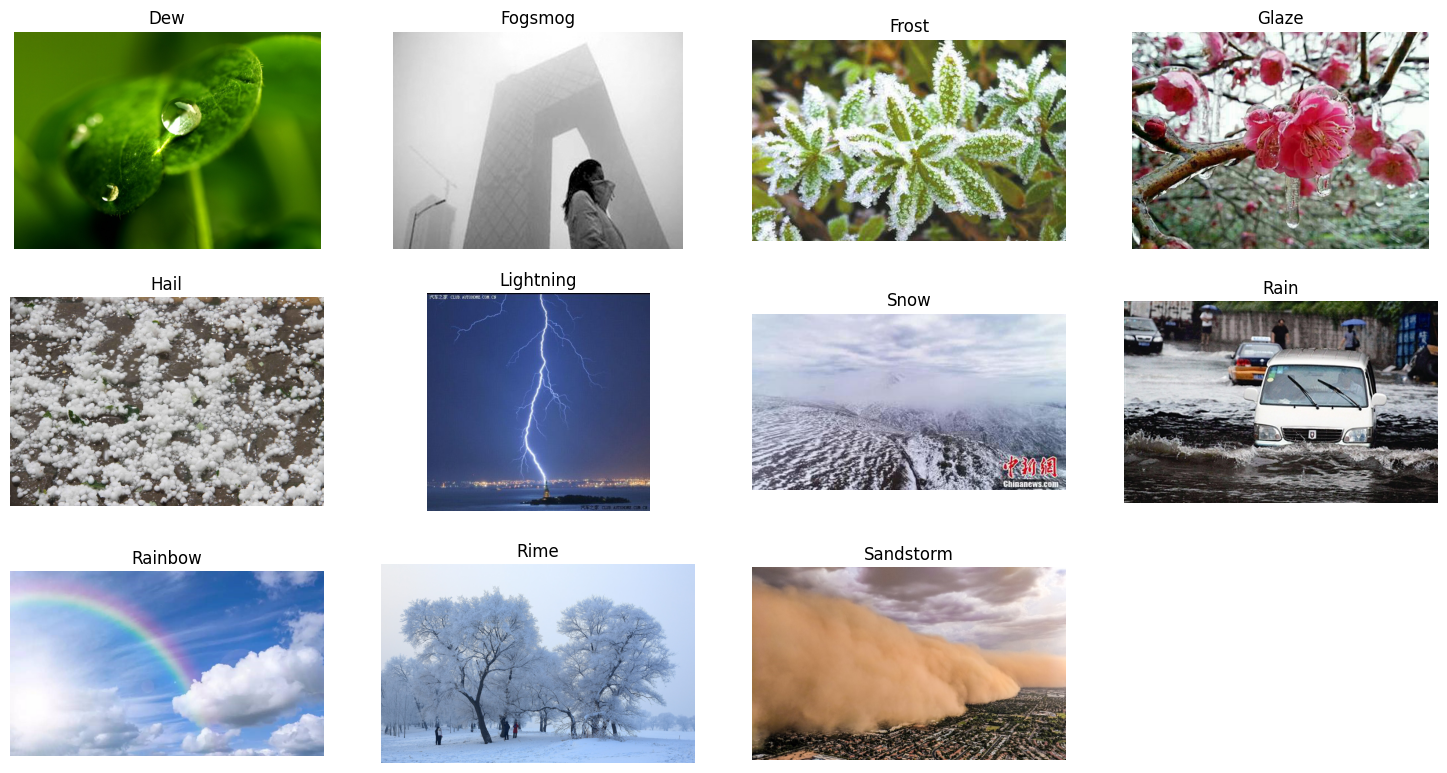

In [308]:
# get df of images we want to plot
images = df.groupby('weather').head(1)

image_plots(images, 3, 4, 15, 8)

<p style="background-color:#000099;color:white;font-style:italic;">As it looks like even the images in this small sample have different resolutions. Let's plot all resolutions to get some idea and later we will resize these images to one size to train CNN model.</p>

In [200]:
fig = px.scatter(df, x='width', y='height', 
             title='<b>Image resolutions</b>', 
             color='width')

fig['layout'].update(height=600)

fig.show()

In [197]:
fig = make_subplots(
    rows=2, 
    cols=2,
    vertical_spacing = 0.1,
    horizontal_spacing = 0.1,
    subplot_titles=(
        "Width Distribution",
        "Height Distribution",
        )
)

# Figure 1
fig.add_trace(
    go.Histogram(
        x=df.width,
        showlegend=False
    ),
    row=1,
    col=1
)

fig['layout']['xaxis1']['title']='Width'
fig['layout']['yaxis1']['title']='Count'

# figure 2
fig.add_trace(
    go.Histogram(
        x=df.height,
        showlegend=False
    ),
    row=1,
    col=2
)

fig['layout']['xaxis2']['title']='Height'
fig['layout']['yaxis2']['title']='Count'

# figure 3
fig.add_trace(
    go.Box(
        y = df.width,
        name='',
        marker_color='#0c8df5',
        boxmean=True,
        showlegend=False
    ), 
    row=2, 
    col=1
)

fig['layout']['yaxis3']['title']='Width'

# figure 4
fig.add_trace(
    go.Box(
        y = df.height,
        name='',
        marker_color='#0c8df5',
        boxmean=True,
        showlegend=False
    ), 
    row=2, 
    col=2
)

fig['layout']['yaxis4']['title']='Height'
fig['layout'].update(height=1000, title='<b>Stacked Subplots with Shared X-Axes</b>')


fig.show()

<p style="background-color:#000099;color:white;font-style:italic;">If we zoom and check distribution and box plots we can see that there are some outliers, for width they are outside both upper and lower fences, and for height they are above upper fence. We need to take a look at images with outliers. Considering the graphs we can try rescaling images to median or 3rd quartile/mean (these two are almost same) of width and height.</p>

In [209]:
w_upper_fence, w_lower_fence = 650, 250
h_upper_fence, h_lower_fence = 616, 91

outliers_df = df.loc[
    (df['width']>w_upper_fence) | \
    (df['width']<w_lower_fence) | \
    (df['height']>h_upper_fence) | \
    (df['height']<h_upper_fence)
    ]

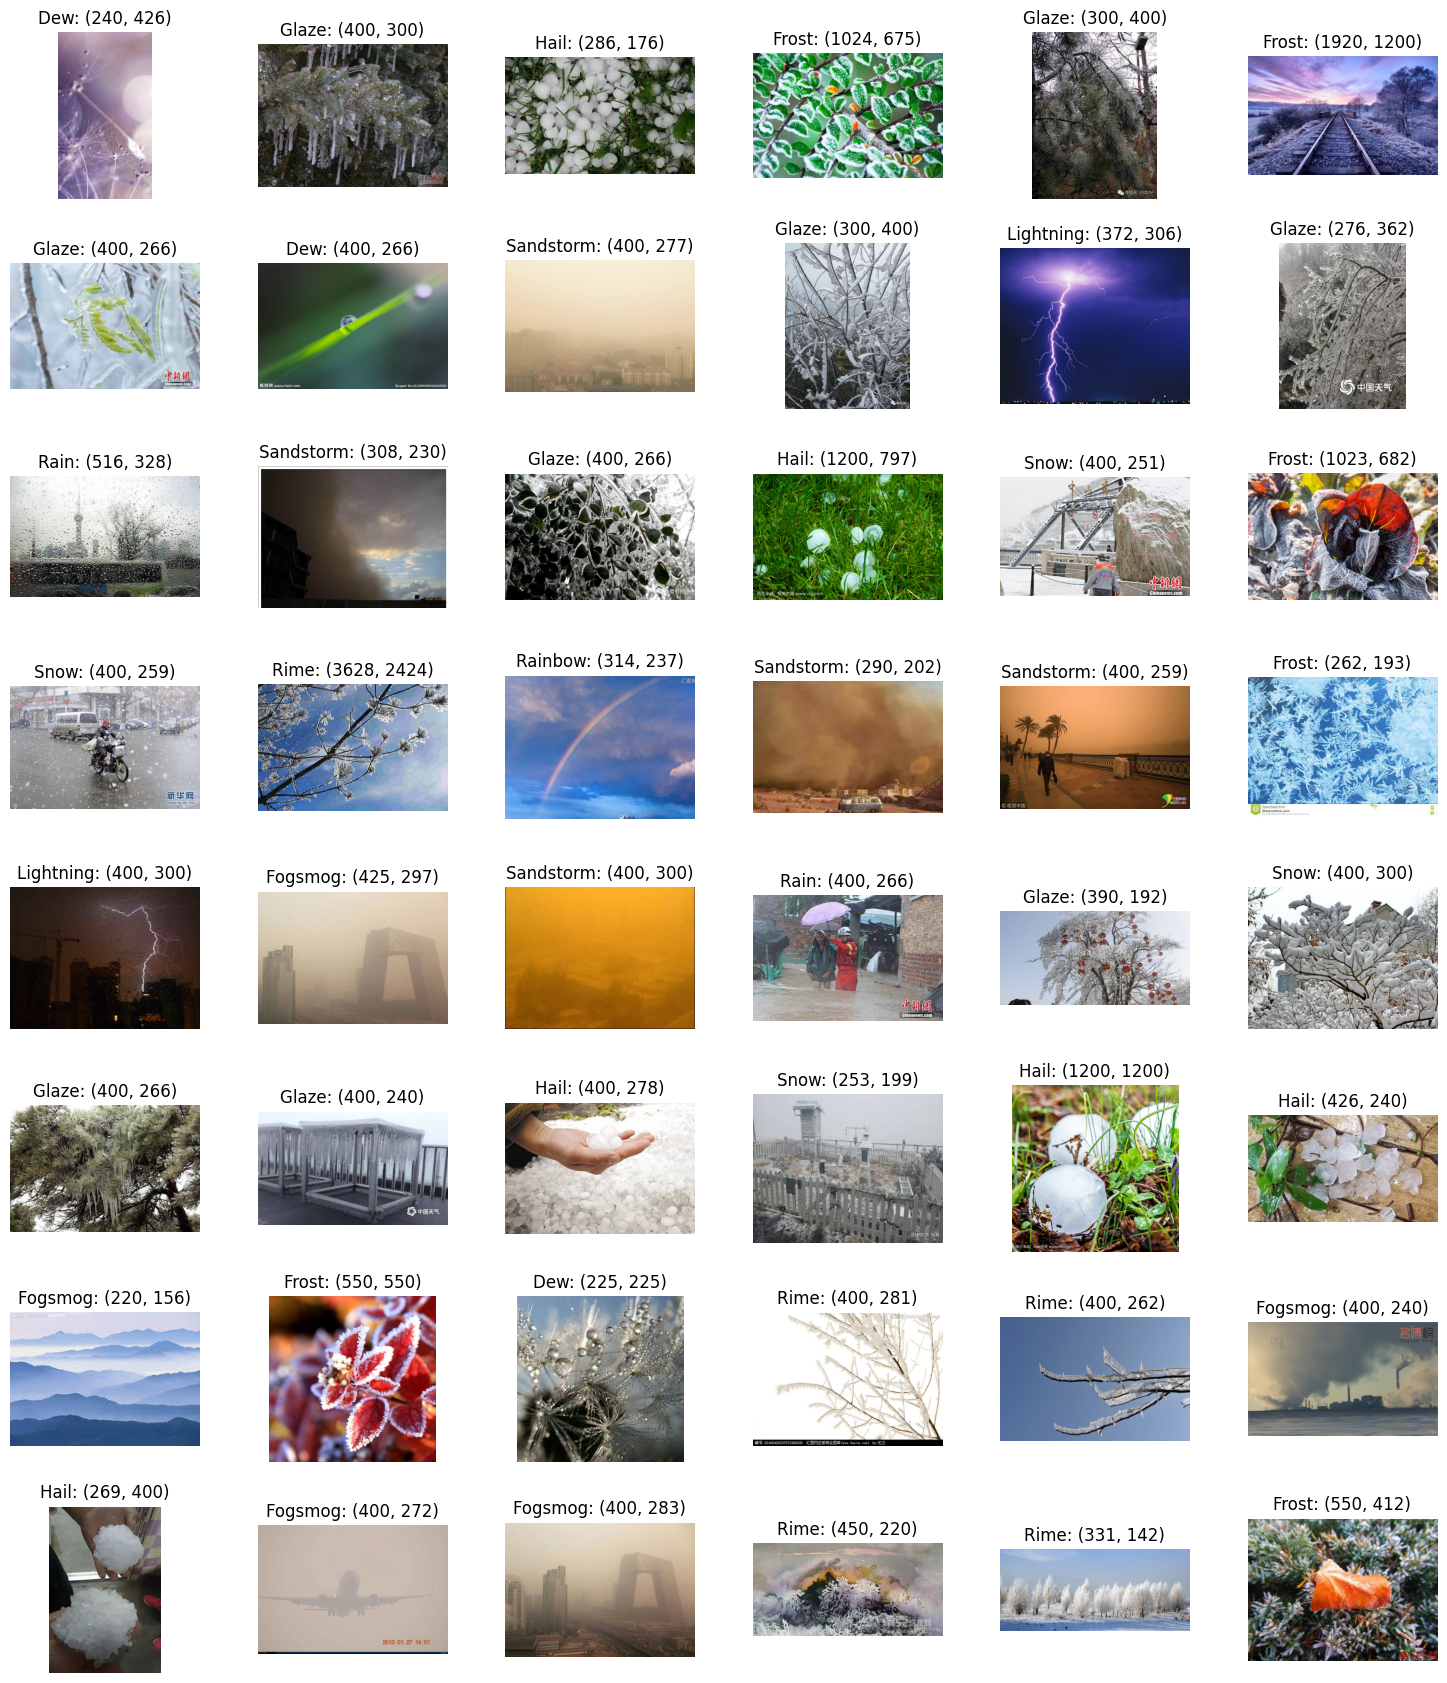

In [311]:
# get random sample of these outliers
outliers = outliers_df.sample(50, random_state=42)

# plot them
image_plots(outliers, 8, 6, 15, 17, True)

<p style="background-color:#000099;color:white;font-style:italic;font-weight:bold">Nothing looks weird with these outliers, they are indeed weather images. Therefore we can rescale them with pillow and use in our model.</p>

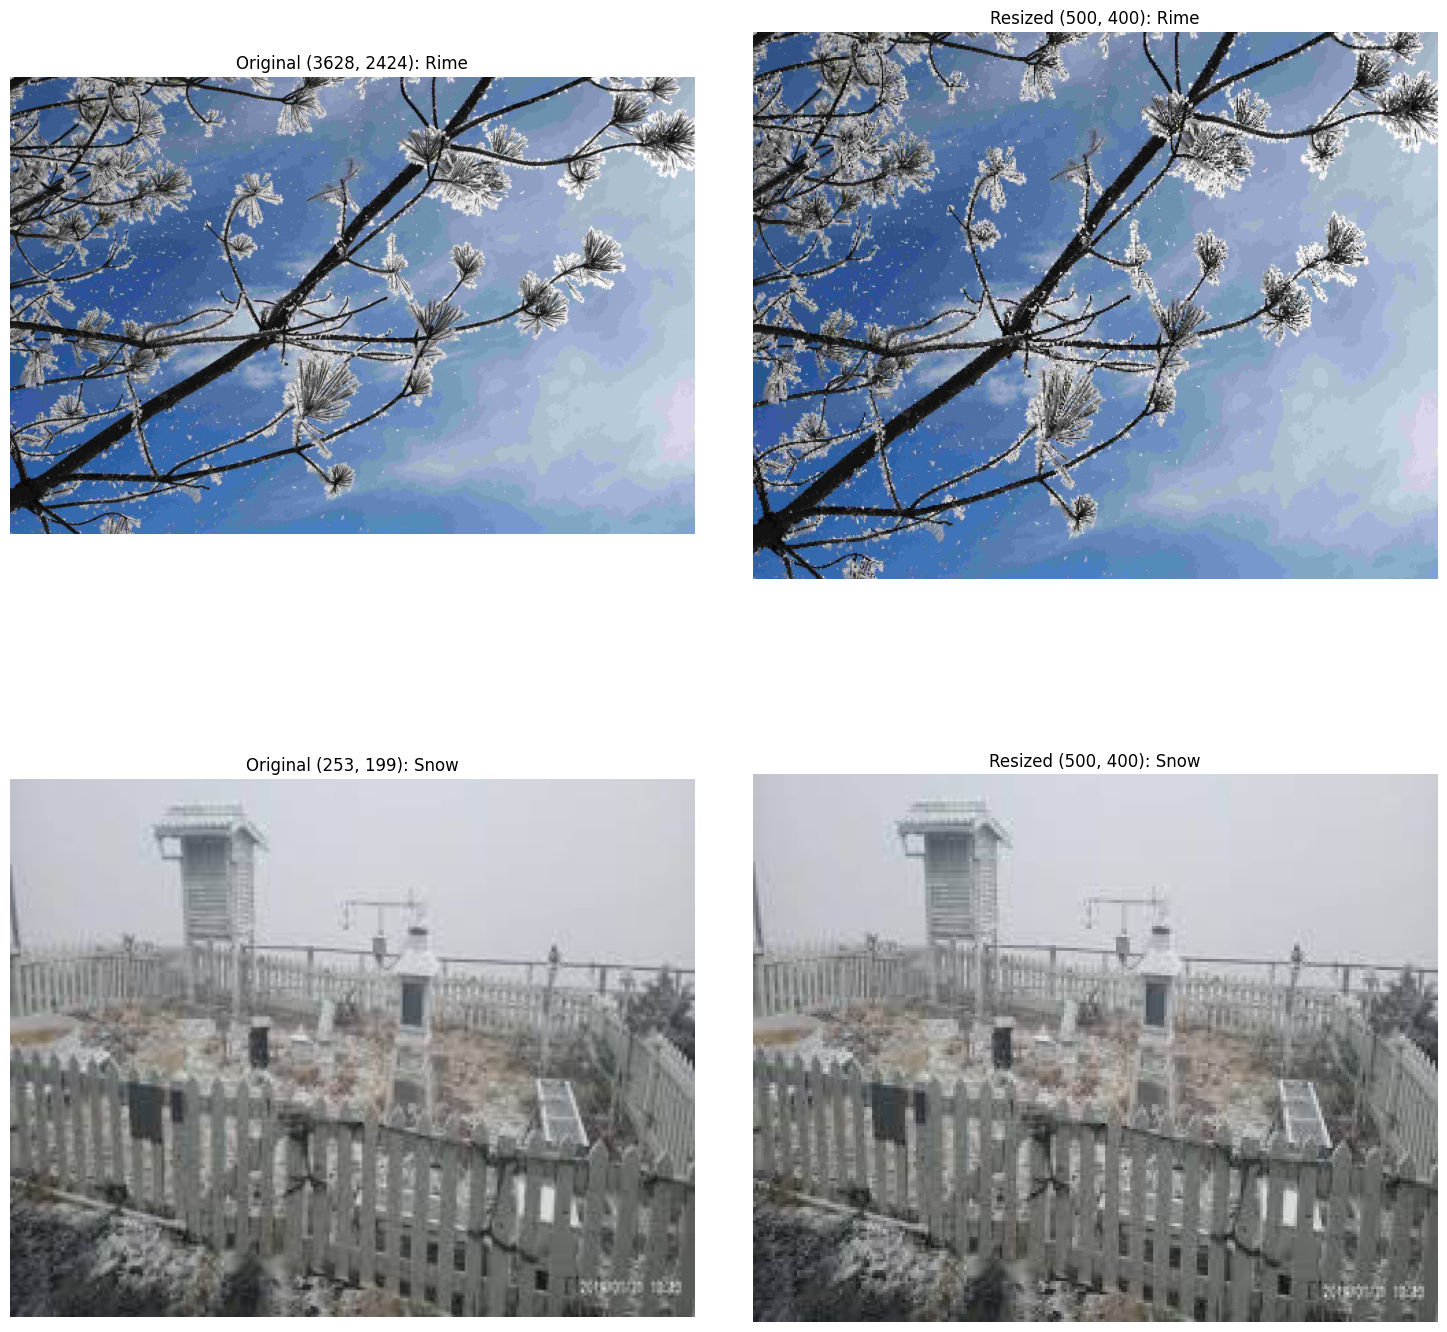

In [329]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.tight_layout()
ax = ax.flatten()

ax[0].imshow(Image.open('Dataset/rime/5425.jpg'))
ax[0].set_title('Original (3628, 2424): Rime')
ax[0].axis('off')

ax[1].imshow(Image.open('Dataset/rime/5425.jpg').resize((500, 400), Image.NEAREST))
ax[1].set_title('Resized (500, 400): Rime')
ax[1].axis('off')

ax[2].imshow(Image.open('Dataset/snow/0900.jpg'))
ax[2].set_title('Original (253, 199): Snow')
ax[2].axis('off')

ax[3].imshow(Image.open('Dataset/snow/0900.jpg').resize((500, 400), Image.NEAREST))
ax[3].set_title('Resized (500, 400): Snow')
ax[3].axis('off')

plt.show;

# Now let's Build Dataset and DataLoader